In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
PATH = "./data"

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (299, 299)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels= "inferred",
    label_mode= "int",
    class_names= ['Good','Bad'],
    color_mode= "rgb",
    batch_size= 32,
    image_size=  (299, 299),
    shuffle= True,
    seed= 69,
    validation_split= None,
    subset= None,
    interpolation="bilinear",
    follow_links=False,
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels= "inferred",
    label_mode= "int",
    class_names= ['Good','Bad'],
    color_mode= "rgb",
    batch_size= 32,
    image_size=  (299, 299),
    shuffle= True,
    seed= 69,
    validation_split= None,
    subset= None,
    interpolation="bilinear",
    follow_links=False,
)

Found 8032 files belonging to 2 classes.
Found 663 files belonging to 2 classes.


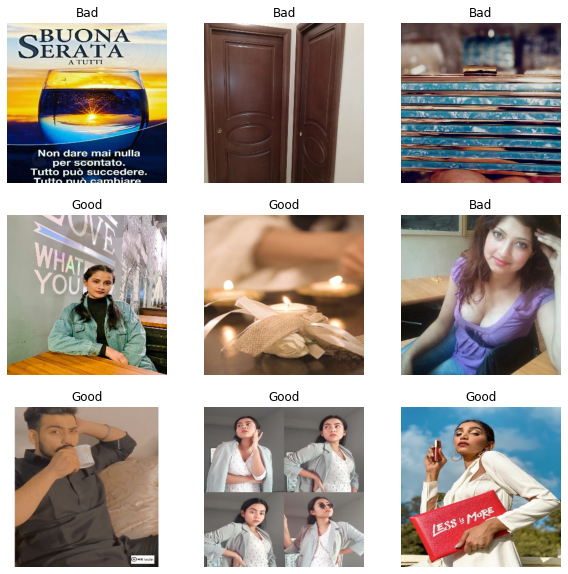

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [6]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [7]:
IMG_SHAPE = (299, 299, 3)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [10]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [11]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr= 0.0001),
              loss= tf.keras.losses.BinaryCrossentropy(from_logits= True),
              metrics= ['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [14]:
len(model.trainable_variables)

2

In [15]:
history = model.fit(train_dataset,
                    epochs= 5,
                   )

Epoch 1/5
251/251 [==============================] - 455s 2s/step - loss: 0.6383 - accuracy: 0.6029
Epoch 2/5
251/251 [==============================] - 462s 2s/step - loss: 0.5125 - accuracy: 0.7442
Epoch 3/5
251/251 [==============================] - 480s 2s/step - loss: 0.4609 - accuracy: 0.7905
Epoch 4/5
251/251 [==============================] - 447s 2s/step - loss: 0.4348 - accuracy: 0.7985
Epoch 5/5
251/251 [==============================] - 450s 2s/step - loss: 0.4195 - accuracy: 0.8124


dict_keys(['loss', 'accuracy'])


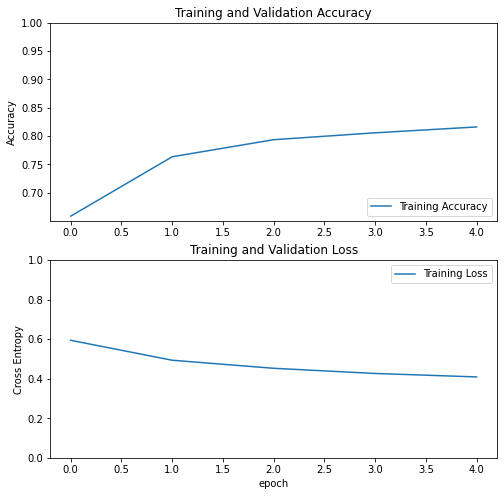

In [16]:
print(history.history.keys())

acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

21/21 [==============================] - 45s 2s/step - loss: 0.6903 - accuracy: 0.6983
Test accuracy : 0.698340892791748


Predictions:
 [1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1]
Labels:
 [0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1]


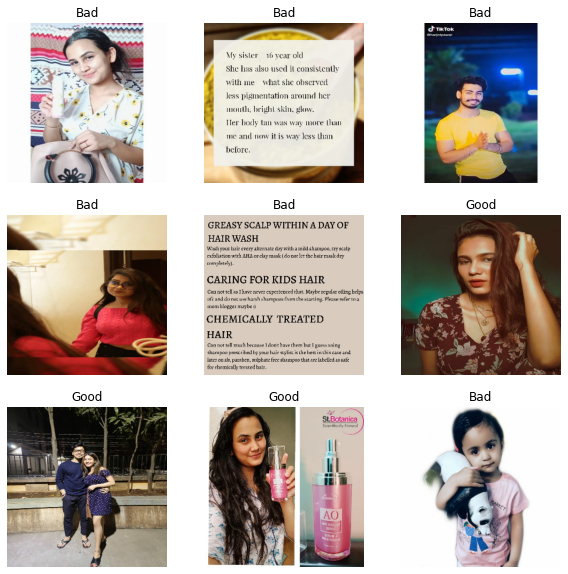

In [18]:
#Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
